In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras import Sequential 
from pathlib import Path
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, MaxPooling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample, choice
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset_path = Path("/content/drive/MyDrive/projectdata/CamVid")
list(dataset_path.iterdir())

[PosixPath('/content/drive/MyDrive/projectdata/CamVid/class_dict.csv'),
 PosixPath('/content/drive/MyDrive/projectdata/CamVid/train'),
 PosixPath('/content/drive/MyDrive/projectdata/CamVid/test'),
 PosixPath('/content/drive/MyDrive/projectdata/CamVid/val_labels'),
 PosixPath('/content/drive/MyDrive/projectdata/CamVid/val'),
 PosixPath('/content/drive/MyDrive/projectdata/CamVid/train_labels'),
 PosixPath('/content/drive/MyDrive/projectdata/CamVid/test_labels')]

In [ ]:
# train/val/test 이미지파일 이름 리스트 
train_img_lst = os.listdir("/content/drive/MyDrive/projectdata/CamVid/train")
val_img_lst = os.listdir("/content/drive/MyDrive/projectdata/CamVid/val")
test_img_lst = os.listdir("/content/drive/MyDrive/projectdata/CamVid/test")

# train/val/test 이미지 개수 
print('number of train images : ', len(train_img_lst))
print('number of val images : ', len(val_img_lst))
print('number of test images : ', len(test_img_lst))

number of train images :  369
number of val images :  100
number of test images :  232


In [ ]:
# train/val/test 이미지/라벨 주소
train_img_dir = '/content/drive/MyDrive/projectdata/CamVid/train'
train_lab_dir = '/content/drive/MyDrive/projectdata/CamVid/train_labels'
val_img_dir = '/content/drive/MyDrive/projectdata/CamVid/val'
val_lab_dir = '/content/drive/MyDrive/projectdata/CamVid/val_labels'
test_img_dir = '/content/drive/MyDrive/projectdata/CamVid/test'
test_lab_dir = '/content/drive/MyDrive/projectdata/CamVid/test_labels'

In [ ]:
def make_pair(img_list, image_dir, label_dir):
  '''
  이미지와 라벨 쌍(튜플)을 만드는 함수
  빈 리스트를 생성하고
  이미지파일 이름 하나씩 불러와서 
  해당 이미지파일의 이름에 해당하는 이미지와 라벨(이미지파일 이름에서 '.' 기준으로 분리해 인덱스 0에 해당하는 부분 + '_L.png') 튜플로 만들기
  이미지는 '0001TP_009210.png', 라벨은 '0001TP_009210_L.png'로 이름이 지정되어있음  
  '''
  pairs = []  
  for img in img_list: 
    pairs.append((image_dir + '/' + img, label_dir + '/' + img.split('.')[0]+'_L.png')) 
  return pairs

In [ ]:
# train/val/test 이미지와 라벨 튜플 만들기 
train_pair = make_pair(train_img_lst, train_img_dir, train_lab_dir)
val_pair = make_pair(val_img_lst, val_img_dir, val_lab_dir)
test_pair = make_pair(test_img_lst, test_img_dir, test_lab_dir)

# 튜플 확인
train_pair[0]

('/content/drive/MyDrive/projectdata/CamVid/train/0001TP_009420.png',
 '/content/drive/MyDrive/projectdata/CamVid/train_labels/0001TP_009420_L.png')

In [ ]:
# 이미지 사이즈
img_size = 512

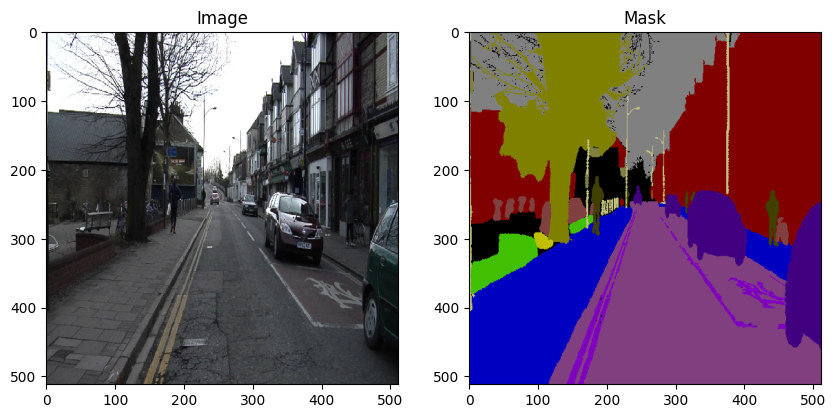

In [ ]:
temp = choice(train_pair)   # 튜플 하나 선택
img = img_to_array(load_img(temp[0], target_size = (img_size, img_size)))   # 튜플의 image 부분
mask = img_to_array(load_img(temp[1], target_size = (img_size, img_size)))   # 튜플의 label 부분

# 이미지/라벨 시각화
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Image")
plt.imshow(img/255)
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask/255)

In [ ]:
# class dictionary 확인 
class_dict = pd.read_csv('/content/drive/MyDrive/projectdata/CamVid/class_dict.csv')
class_dict

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [ ]:
# class rgb array 리스트 만들기 
class_map = []   
for index,item in class_dict.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))   # rgb 값을 array로 만들어 빈 리스트(class_map)에 담기

# 확인    
print('class 개수 : ',len(class_map))
print('리스트 속 첫 리스트 : ', class_map[0])

class 개수 :  32
리스트 속 첫 리스트 :  [ 64 128  64]


In [ ]:
# 데이터 증강을 위한 함수 
data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness([-0.5, 0.8]),
    layers.RandomContrast([0.8, 1.2]),
    layers.RandomCrop(100,100),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
])

In [ ]:
def assert_map_range(mask,class_map):
  '''
  mask 부분이 클래스 라벨 값만 포함하도록 하는 함수
  클래스 딕셔너리에 32개 존재하므로
  예측 mask 값은 0~31 사이의 값이 포함되어 해당 RGB에 매핑될 수 있도록 함  
  '''
  mask = mask.astype("uint8")   # uint8 : 2^8개수 만큼 표현(0~255)
  for j in range(img_size):
    for k in range(img_size):
      assert mask[j][k] in class_map , tuple(mask[j][k])

In [ ]:
def form_2D_label(mask,class_map):
  '''
  학습될 마스크를 rgb에서 클래스 라벨을 보유한 2D 이미지로 변환하는 함수
  '''
  mask = mask.astype("uint8")
  label = np.zeros(mask.shape[:2],dtype= np.uint8)   # mask.shape -> (256,256,3), mask.shape[:2] -> (256,256)
    
  for i, rgb in enumerate(class_map):
      label[(mask == rgb).all(axis=2)] = i   # axis=2 -> 참고자료 : http://taewan.kim/post/numpy_sum_axis/
  return label

In [ ]:
# 위에서 시각화로 봤던 마스크에 대한 라벨
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([ 4,  5,  8, 10, 12, 14, 16, 17, 19, 21, 26, 29, 30, 31],
       dtype=uint8),
 array([63099, 16687,  3228,  4622,   615,  2947,  2028, 59644, 33881,
        28769, 30363,   482, 10936,  4843]))

In [ ]:
# generator 만들기 -> 참고자료 : https://aistudy9314.tistory.com/34
class DataGenerator(Sequence):
  '''
  이 클래스는 이미지 레이블 페어를 가져와 이미지와 2d 레이블이 지정된 마스크를 반환하는 사용자 지정 데이터 생성기
  '''
  def __init__(self, pair, class_map, batch_size = 16, dim=(224, 224, 3), shuffle = True):
    self.pair = pair
    self.class_map = class_map
    self.batch_size = batch_size
    self.dim = dim
    self.shuffle = shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    '''
    이 함수는 하나의 epoch이 끝나고 다음 epoch이 시작되기 전에 호출되는 메서드
    이 하나의 epoch이 끝날 때마다 데이터셋의 순서를 변경해 모델이 다음 epoch에서 데이터를 다양하게 학습할 수 있도록 함  
    '''
    self.idxs = np.arange(len(self.pair))
    if self.shuffle == True:   
      np.random.shuffle(self.idxs)    # 데이터의 순서 셔플

  def __len__(self):
    '''
    step size(length of data / batch size)를 리턴
    '''
    return int(np.floor(len(self.pair) / self.batch_size))   # np.floor : 소수점 이하를 버리고 정수만 남김 

  def __getitem__(self, idx):
    '''
    한 epoch 동안 0부터 __len__함수에서 얻은 step size까지를 순서대로, 
    idx 인자로 받아서 데이터를 batch단위로 나누고, 
    전처리와 증강 작업 후 실제 모델에 input이 될 데이터가 return 되는 부분
    '''
    idxs = self.idxs[idx*self.batch_size:(idx+1)*self.batch_size]   # idx*self.batch_size와 (idx+1)*self.batch_size를 슬라이스 값으로 사용해 현재 배치의 시작 인덱스와 끝 인덱스를 추출할 수 있음
    list_IDs_temp = [k for k in idxs]   # self.idxs리스트에서 해당되는 위치의 인덱스 추출(idxs)해 list_IDs_temp에 저장
    X, y = self.data_gen(list_IDs_temp)   # data_gen에서 출력된 batch_imgs와 batch_labels을 X와 y값으로 받음
    return X, y

  def data_gen(self, list_IDs_temp):
    '''
    데이터셋에서 배치 단위로 데이터를 불러오는 역할
    '''
    batch_imgs = list()   # 입력 이미지 저장
    batch_labels = list()   # 출력 라벨 저장

    for i in list_IDs_temp:
      img = load_img(self.pair[i][0], target_size = self.dim)   # list_IDs_temp에서 i번째 인덱스에 해당하는 이미지를 받아와 target_size로 사이즈를 바꿔줌
      img = img_to_array(img) / 255.   # 넘파이 배열로 변환한 뒤 정규화
      batch_imgs.append(img)

      label = load_img(self.pair[i][1], target_size = self.dim)   # list_IDs_temp에서 i번째 인덱스에 해당하는 라벨을 불러와 리사이징 해줌
      label = img_to_array(label)   # 넘파이 배열로 변환
      label = form_2D_label(label, self.class_map)   # 2차원을 1차원으로 변환
      label = to_categorical(label, num_classes = 32)   # 라벨을 원핫인코딩된 벡터형태로 변환
      batch_labels.append(label)

    return np.array(batch_imgs), np.array(batch_labels)

In [ ]:
# 각 데이터셋에 대해 DataGenerator 적용
train_generator = DataGenerator(train_pair, class_map, batch_size = 8, dim = (img_size, img_size, 3), shuffle = True)
val_generator = DataGenerator(val_pair, class_map, batch_size = 8, dim = (img_size, img_size, 3), shuffle = True)
test_generator = DataGenerator(test_pair, class_map, batch_size = 8, dim = (img_size, img_size, 3), shuffle = True)

In [ ]:
# 컨볼루션 블록을 구현한 함수
def conv_block(tensor, nfilters, size=3, padding = 'same', initializer = 'he_normal'):    
  '''
  입력 데이터의 특성을 추출하는데 사용(더 많은 특성을 추출하기 위해 2번 반복)
  '''
  x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)   # 컨볼루션 연산 수행
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

# 디컨볼루션 블록을 구현한 함수
def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
  '''
  입력 데이터의 공간적 정보를 복원하는데 사용(컨볼루션과 달리 한번만 적용하는 이유는 더 많이 공간적 정보가 손실되는 것을 막기위해)
  '''
  y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)   # 업샘플링 연산 수행
  y = concatenate([y, residual], axis=3)
  y = conv_block(y, nfilters)
  return y

In [ ]:
def Unet(h, w, filters, num_classes = 32):
  
  input_layer = Input(shape=(h, w, 3), name='image_input')
  conv1 = conv_block(input_layer, nfilters=filters)
  conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = conv_block(conv1_out, nfilters=filters*2)
  conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = conv_block(conv2_out, nfilters=filters*4)
  conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = conv_block(conv3_out, nfilters=filters*8)
  conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
  conv4_out = Dropout(0.5)(conv4_out)
  conv5 = conv_block(conv4_out, nfilters=filters*16)
  conv5 = Dropout(0.5)(conv5)

  deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
  deconv6 = Dropout(0.5)(deconv6)
  deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
  deconv7 = Dropout(0.5)(deconv7) 
  deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
  deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
  output_layer = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(deconv9)

  model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
  return model

In [ ]:
model = Unet(img_size, img_size, 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
mc = ModelCheckpoint(mode='max', filepath='top-weights-na.h5', monitor='val_accuracy',save_best_only='True', verbose=1)   # 모델 학습 중에 모델의 가중치를 저장 
es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)

In [ ]:
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()

In [ ]:
results = model.fit_generator(train_generator, 
                              steps_per_epoch=train_steps,
                              epochs=30,
                              validation_data=val_generator,
                              validation_steps=val_steps,
                              callbacks=[mc,es],
                              verbose = 1)

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.7712
Epoch 1: val_accuracy improved from -inf to 0.51870, saving model to top-weights-na.h5
46/46 [==============================] - 209s 5s/step - loss: 0.8272 - accuracy: 0.7712 - val_loss: 2.1965 - val_accuracy: 0.5187
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 0.7679 - accuracy: 0.7859
Epoch 2: val_accuracy improved from 0.51870 to 0.60133, saving model to top-weights-na.h5
46/46 [==============================] - 210s 5s/step - loss: 0.7679 - accuracy: 0.7859 - val_loss: 1.7691 - val_accuracy: 0.6013
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 0.7289 - accuracy: 0.7964
Epoch 3: val_accuracy improved from 0.60133 to 0.71686, saving model to top-weights-na.h5
46/46 [==============================] - 211s 5s/step - loss: 0.7289 - accuracy: 0.7964 - val_loss: 1.0559 - val_accuracy: 0.7169
Epoch 4/30
46/46 [==============================] - ETA: 0s -

In [ ]:
model.save('/content/drive/MyDrive/projectdata')

In [ ]:
trained_model = keras.models.load_model('/content/drive/MyDrive/projectdata')

In [ ]:
# 평가
trained_model.evaluate_generator(test_generator, verbose=1)

29/29 [==============================] - 414s 15s/step - loss: 0.9261 - accuracy: 0.7726


[0.9261211156845093, 0.7726292610168457]

In [ ]:
# 예측
x_test, y_test = test_generator.__getitem__(2)
y_pred = trained_model.predict(x_test, verbose = 1, batch_size = 4)
y_pred.shape

2/2 [==============================] - 10s 13ms/step


(8, 512, 512, 32)

In [ ]:
def map_this(y_pred,class_map):
  y_pred_rgb = np.zeros((y_pred.shape[0],y_pred.shape[1],y_pred.shape[2],3))
  for i in range(y_pred.shape[0]):
      image = np.zeros((y_pred.shape[1],y_pred.shape[2],3))
      for j in range(y_pred.shape[1]):
          for k in range(y_pred.shape[2]):
              image[j,k,:] = class_map[y_pred[i][j][k]]
      y_pred_rgb[i] = image
  return y_pred_rgb

def plot_result(img , title):
  plt.figure(figsize=(12, 6))
  plt.title(title)
  for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(img[i].astype('uint8'))
  plt.show()

In [ ]:
pred = np.argmax(y_pred, axis=3)
y_pred_rgb = map_this(pred,class_map)
test = np.argmax(y_test, axis=3)
y_test_rgb = map_this(test,class_map)

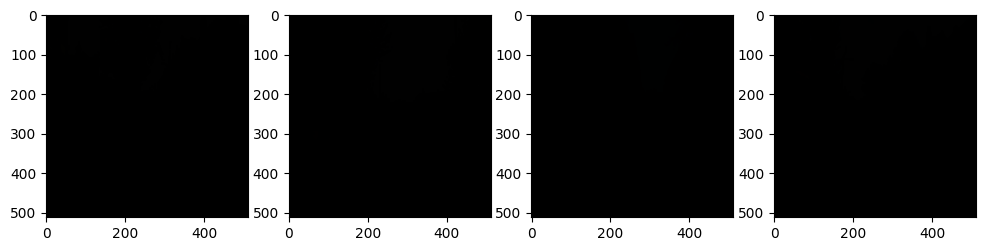

In [ ]:
# 실제 image
plot_result(x_test,"Test Images")

(코드 실행시켰을 때 실제 이미지가 잘 나왔는데 몇 번 스크롤 오르내리면서 버벅거리더니 사진이 까맣게 변했습니다ㅜ)

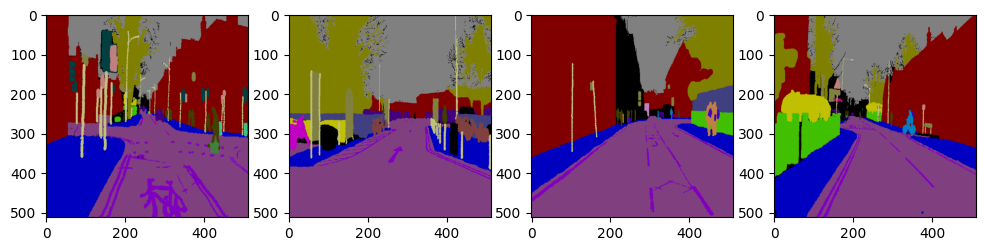

In [ ]:
# 실제 mask
plot_result(y_test_rgb,"Original Masks")

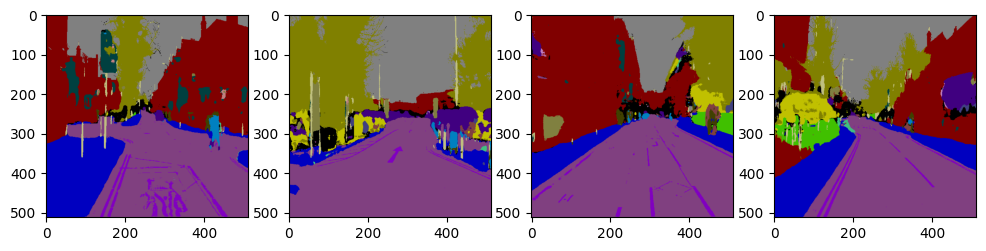

In [ ]:
# 예측 mask
plot_result(y_pred_rgb,"Predicted mask")